# Configuración del Entorno y Carga de Datos

In [ ]:
import numpy as np 
import pandas as pd
from scipy import signal
from scipy.signal import decimate, spectrogram
from scipy import *
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import scipy.signal
from scipy import *
import copy
if "COLAB_GPU" in os.environ:
    !pip install neurokit2
    !pip install pyampd
import neurokit2 as nk
from pyampd.ampd import find_peaks
# Verificar el directorio de trabajo actual
print("Directorio de trabajo actual:", os.getcwd())

Directorio de trabajo actual: /content


## Funciones de Temperatura y Espectograma

In [8]:
def temp_uv_to_celsius(analog_uV, vref=3.3):
    V = analog_uV * 1e-6
    V = np.clip(V, 1e-6, vref - 1e-6)
    R_ntc = 56000 * (V / (vref - V))
    R_ntc = np.clip(R_ntc, 1e-6, None)
    T_K = 1 / (0.003354 + (np.log(R_ntc / 10000) / 3435))
    T_celsius = T_K - 273.15
    return T_celsius

In [9]:
def plot_spectrogram(signal, fs, M=1):
    from scipy.signal import decimate, spectrogram
    
    #Diezmar 
    if M > 1:
        signal = decimate(signal, M, ftype='fir', zero_phase=True)
        fs = fs / M

    # Ventana de 3 segundos
    nperseg = int(fs * 3)
    f, t, Sxx = spectrogram(signal, fs=fs, nperseg=nperseg)
    
    
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx + 1e-10), shading='gouraud')
    plt.ylabel('Frecuencia [Hz]')
    plt.xlabel('Tiempo [s]')
    plt.colorbar(label='dB')
    plt.title(f'Espectrograma (fs={fs}Hz)')
    plt.show()



## Definición de Rutas y Carga de Archivos


In [10]:
# Detectar si estamos en Google Colab
if "COLAB_GPU" in os.environ:
    
    print("Entorno detectado: Google Colab")
    
    from google.colab import drive
    drive.mount('/content/drive')
    
    DATA_DIR = "/content/drive/MyDrive/DACIU/datos"
    
    path_analog = os.path.join(DATA_DIR, "versabio2725_analog.csv")
    path_exg    = os.path.join(DATA_DIR, "versabio2725_exg.csv")
    path_imu    = os.path.join(DATA_DIR, "versabio2725_imu.csv")

else:
    
    print("Entorno detectado: Local")
    
    path_analog = '../datos/versabio2725_analog.csv'
    path_exg    = '../datos/versabio2725_exg.csv'
    path_imu    = '../datos/versabio2725_imu.csv'


# Carga de datos (común a ambos casos)
analog = pd.read_csv(path_analog)
exg    = pd.read_csv(path_exg)
imu    = pd.read_csv(path_imu)

print("He cargado los datos correctamente")
print("Analog shape:", analog.shape)
print("EXG shape:", exg.shape)
print("IMU shape:", imu.shape)

Entorno detectado: Google Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
He cargado los datos correctamente
Analog shape: (606928, 10)
EXG shape: (606928, 12)
IMU shape: (75866, 12)


In [11]:
analog.head()

ch1           ch2            ch3          ch4          ch5  \
0  201584.312725  1.773273e+06  450256.468391  7439.679050  7335.233974   
1  201543.660450  1.773275e+06  450233.640575  7431.235886  7357.749081   
2  201591.817760  1.773324e+06  450249.588776  7427.170658  7351.494884   
3  201508.949661  1.773271e+06  450250.839615  7435.926533  7342.426300   
4  201624.026871  1.773230e+06  450250.526905  7420.291042  7331.794167   

            ch6          ch7  sequenceNumber  timestampReception     timestamp  
0  1.967777e+06  8421.587849           17527        2.176906e+10  2.176899e+10  
1  1.967653e+06  8466.305351           17527        2.176906e+10  2.176899e+10  
2  1.967640e+06  8441.913986           17527        2.176906e+10  2.176899e+10  
3  1.967820e+06  8422.525978           17527        2.176906e+10  2.176900e+10  
4  1.967804e+06  8448.168182           17527        2.176906e+10  2.176900e+10

In [12]:
exg.head()

ch1          ch2          ch3          ch4          ch5  \
0 -3665.548575  1362.761970  1280.057069  1315.539630  1422.197891   
1 -3667.075273  1361.919654  1282.426083  1317.645420  1419.723588   
2 -3658.652113  1362.919904  1281.373188  1317.750709  1417.512508   
3 -3633.803791  1359.497995  1277.266897  1314.012932  1421.566154   
4 -3636.436029  1360.656180  1277.898634  1315.171117  1418.249535   

           ch6          ch7          ch8          ch9  sequenceNumber  \
0  1098.590620  1085.166209  1119.753809  1199.615893           17527   
1  1102.538976  1089.535723  1123.807454  1200.984656           17527   
2  1099.538225  1085.745301  1117.963887  1199.352669           17527   
3  1095.695158  1082.007524  1117.016282  1200.405564           17527   
4  1099.432936  1085.008274  1117.805953  1202.300775           17527   

   timestampReception     timestamp  
0        2.176906e+10  2.176899e+10  
1        2.176906e+10  2.176899e+10  
2        2.176906e+10  2.176899e+10  
3        2.176906e+10  2.176900e+10  
4        2.176906e+10  2.176900e+10

In [13]:
imu.head()

ch1       ch2       ch3       ch4       ch5       ch6        ch7  \
0 -8.926709  0.275146  4.313818  0.060976  0.609756  0.060976  33.299834   
1 -8.984131  0.337354  4.373633  0.000000  1.097561 -0.548780  32.999835   
2 -8.960205  0.253613  4.409521 -1.189024  0.609756 -0.914634  34.649827   
3 -8.893213  0.284717  4.282715 -1.189024  0.457317 -0.548780  33.899831   
4 -8.886035  0.332568  4.316211 -0.701220  0.548780 -0.304878  33.599832   

         ch8       ch9  sequenceNumber  timestampReception     timestamp  
0  -8.849956 -6.899966           17527        2.176906e+10  2.176899e+10  
1  -8.849956 -6.149969           17528        2.176909e+10  2.176902e+10  
2 -10.349948 -6.299969           17529        2.176914e+10  2.176905e+10  
3  -8.699957 -7.049965           17530        2.176916e+10  2.176908e+10  
4  -7.949960 -6.749966           17531        2.176919e+10  2.176911e+10

In [14]:
bvp = analog["ch1"]
bvp.head()

0    201584.312725
1    201543.660450
2    201591.817760
3    201508.949661
4    201624.026871
Name: ch1, dtype: float64

In [15]:
gsr = analog["ch2"]
gsr.head()

0    1.773273e+06
1    1.773275e+06
2    1.773324e+06
3    1.773271e+06
4    1.773230e+06
Name: ch2, dtype: float64

In [16]:
temp = analog["ch3"]
temp.head()

0    450256.468391
1    450233.640575
2    450249.588776
3    450250.839615
4    450250.526905
Name: ch3, dtype: float64

In [17]:
emg = exg["ch1"]
emg.head()

0   -3665.548575
1   -3667.075273
2   -3658.652113
3   -3633.803791
4   -3636.436029
Name: ch1, dtype: float64

In [18]:
ax = imu["ch1"]
ay = imu["ch2"]
az = imu["ch3"]

## Frecuencias de muestreo de cada señal y ejes de tiempo

In [19]:
fs_analog = 256
fs_exg = 256
fs_imu = 32

t_analog = np.arange(len(analog)) / fs_analog
t_exg = np.arange(len(exg)) / fs_exg
t_imu = np.arange(len(imu)) / fs_imu


## Ploteo con neuro2kit

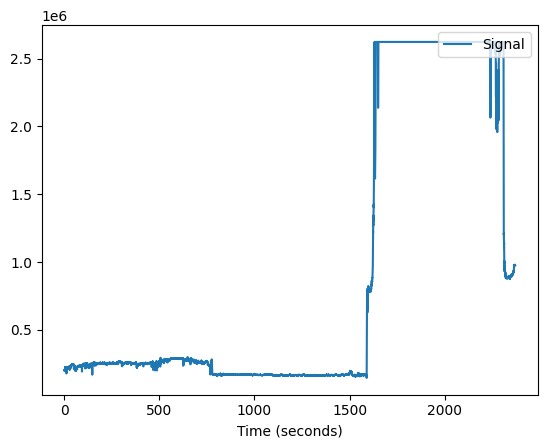

In [20]:
nk.signal_plot(bvp, sampling_rate=fs_analog)

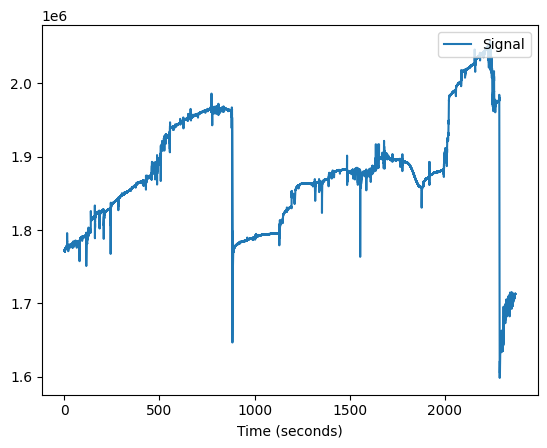

In [21]:
nk.signal_plot(gsr, sampling_rate=fs_analog)

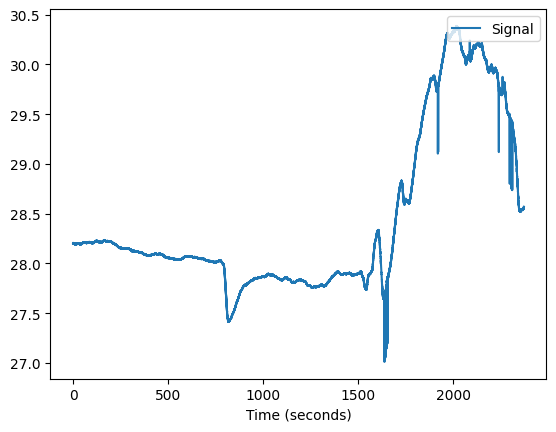

In [22]:
temp_celsius = temp_uv_to_celsius(temp)
nk.signal_plot(temp_celsius, sampling_rate=fs_analog)

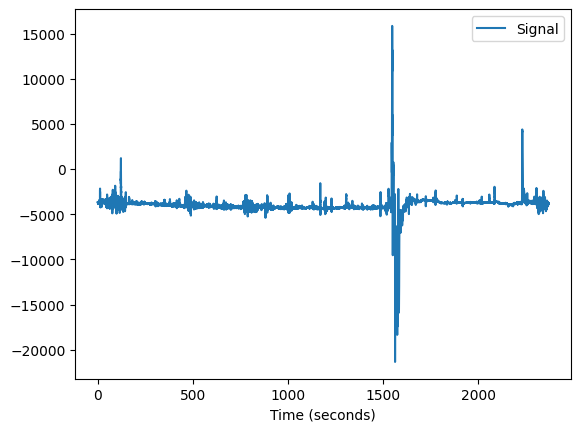

In [23]:
nk.signal_plot(emg, sampling_rate=fs_analog)

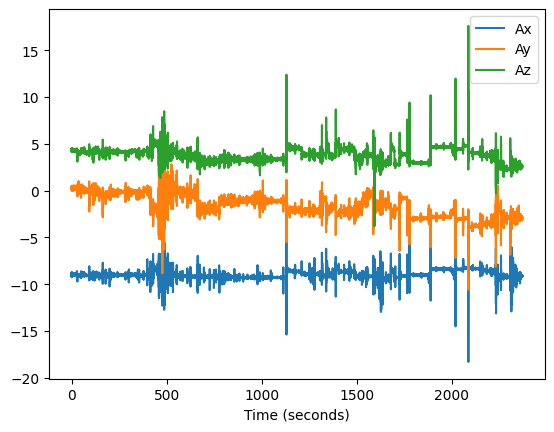

In [24]:
nk.signal_plot( [ax, ay, az], sampling_rate=fs_imu, labels=["Ax", "Ay", "Az"])

## Diezmado

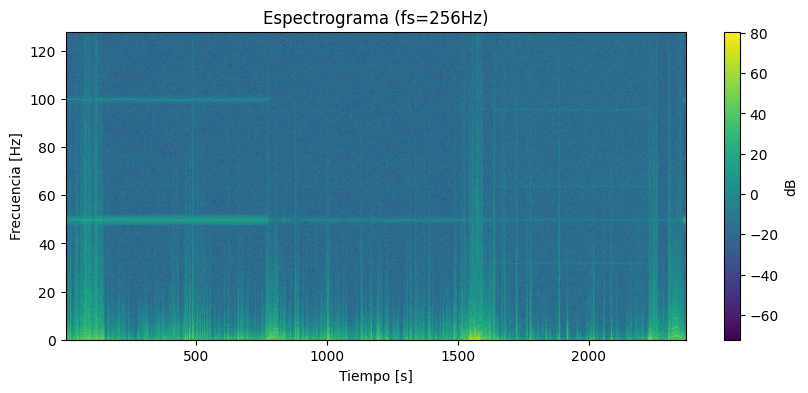

In [25]:
plot_spectrogram(emg, fs_exg, M=1)

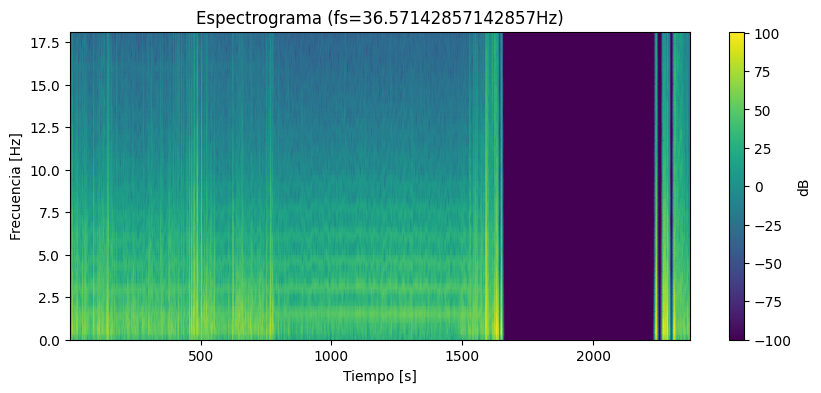

In [26]:
bvp_clean = nk.ppg_clean(bvp, sampling_rate=fs_analog)
plot_spectrogram(bvp_clean, fs_analog, M=7)

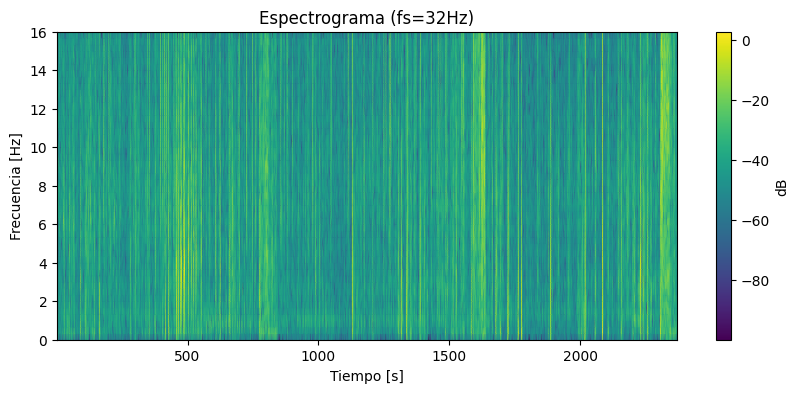

In [27]:
plot_spectrogram(ax, fs_imu, M=1)

## Prueba de HR con el paper

num peaks: 2234
first 10 peaks idx: [   6  249  419  552  719 1014 1488 1628 1853 2316]
first 10 peaks time (s): [0.0234375  0.97265625 1.63671875 2.15625    2.80859375 3.9609375
 5.8125     6.359375   7.23828125 9.046875  ]


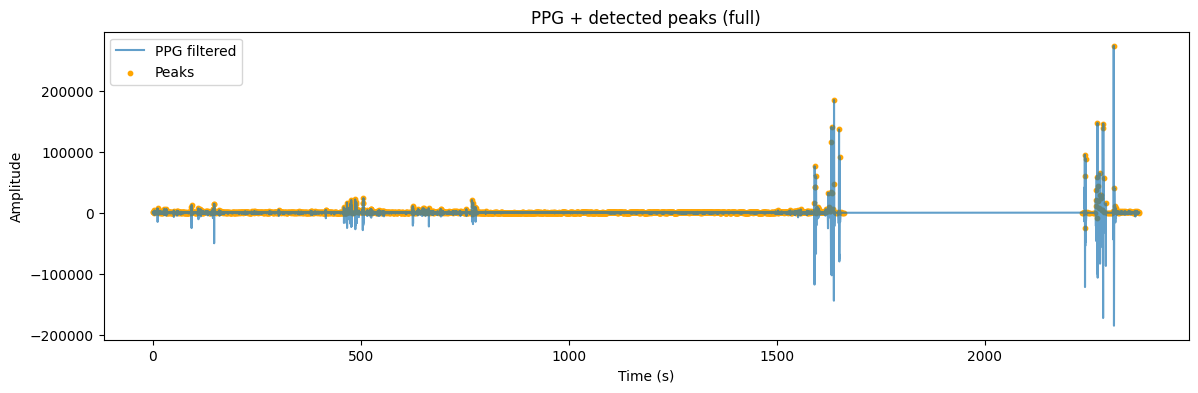

In [28]:
hr_max_bpm = 200
min_period = 60 / hr_max_bpm          
scale = int(1.5 * min_period * fs_analog)    # limita escalas => "fast"

peaks = find_peaks(bvp_clean, scale=scale)    # índices de picos
print("num peaks:", len(peaks))
print("first 10 peaks idx:", peaks[:10])
print("first 10 peaks time (s):", (peaks[:10] / fs_analog))

plt.figure(figsize=(14,4))
plt.plot(t_analog, bvp_clean, label="PPG filtered", alpha=0.7)
plt.scatter(t_analog[peaks], bvp_clean[peaks], color="orange", s=10, label="Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.title("PPG + detected peaks (full)")
plt.show()

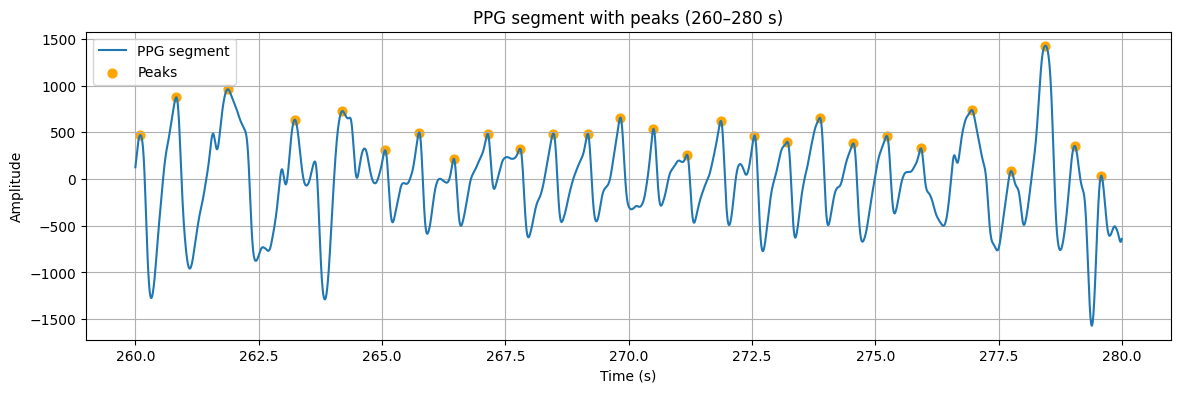

Num peaks in segment: 27


In [29]:
# intervalo de interés
t0, t1 = 260, 280
i0, i1 = int(t0 * fs_analog), int(t1 * fs_analog)

# segmento
seg = bvp_clean[i0:i1]
seg_detrended = scipy.signal.detrend(seg)

# escala máxima 
scale = int(1.5 * min_period * fs_analog)

# picos en el segmento 
peaks = find_peaks(seg_detrended, scale=scale)

# tiempo local del segmento
t_seg = t_analog[i0:i1]

# plot
plt.figure(figsize=(14,4))
plt.plot(t_seg, seg, label="PPG segment", linewidth=1.5)
plt.scatter(
    t_seg[peaks],
    seg[peaks],
    color="orange",
    s=40,
    label="Peaks"
)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("PPG segment with peaks (260–280 s)")
plt.legend()
plt.grid(True)
plt.show()

print("Num peaks in segment:", len(peaks))

In [31]:
tiempo_peaks = peaks / fs_analog
intervalos_latidos = np.diff(tiempo_peaks)
t_intervalos= (tiempo_peaks[1:] + tiempo_peaks[:-1]) / 2
print(t_intervalos)
print(intervalos_latidos)

frecuencia = 60 / intervalos_latidos
print(f'Frecuencia Cardiaca: {frecuencia}')

frecuencia_media = 60 / np.mean(intervalos_latidos)
print(f"Media Frecuencia Cardiaca ≈ {frecuencia_media:.1f} bpm")

[ 0.46484375  1.3515625   2.5546875   3.71679688  4.63085938  5.40820312
  6.10546875  6.79882812  7.46875     8.13671875  8.82421875  9.50195312
 10.16796875 10.84375    11.52734375 12.2109375  12.88476562 13.546875
 14.21484375 14.89257812 15.578125   16.44140625 17.35546875 18.1015625
 18.74609375 19.3125    ]
[0.7265625  1.046875   1.359375   0.96484375 0.86328125 0.69140625
 0.703125   0.68359375 0.65625    0.6796875  0.6953125  0.66015625
 0.671875   0.6796875  0.6875     0.6796875  0.66796875 0.65625
 0.6796875  0.67578125 0.6953125  1.03125    0.796875   0.6953125
 0.59375    0.5390625 ]
Frecuencia Cardiaca: [ 82.58064516  57.31343284  44.13793103  62.18623482  69.50226244
  86.77966102  85.33333333  87.77142857  91.42857143  88.27586207
  86.29213483  90.88757396  89.30232558  88.27586207  87.27272727
  88.27586207  89.8245614   91.42857143  88.27586207  88.78612717
  86.29213483  58.18181818  75.29411765  86.29213483 101.05263158
 111.30434783]
Media Frecuencia Cardiaca ≈ 80.

In [ ]:
def plot_spectrogram_param(signal,
                           fs,
                           factor_diezmado=1,
                           duracion_ventana=3,
                           solapamiento=0.5,
                           tipo_ventana='hann'):

    from scipy.signal import decimate, spectrogram
    import numpy as np
    import matplotlib.pyplot as plt

    
    if factor_diezmado > 1:
        signal = decimate(signal,
                          factor_diezmado,
                          ftype='fir',
                          zero_phase=True)
        fs = fs / factor_diezmado

    
    nperseg = int(fs * duracion_ventana)
    noverlap = int(nperseg * solapamiento)

    
    f, t, Sxx = spectrogram(signal,
                            fs=fs,
                            window=tipo_ventana,
                            nperseg=nperseg,
                            noverlap=noverlap)

    
    plt.figure(figsize=(10,4))
    plt.pcolormesh(t,
                   f,
                   10*np.log10(Sxx + 1e-10),
                   shading='gouraud')

    plt.ylabel("Frecuencia [Hz]")
    plt.xlabel("Tiempo [s]")
    plt.colorbar(label="dB")
    plt.title(f"fs={fs:.1f} Hz | M={factor_diezmado} | "
              f"Ventana={duracion_ventana}s | "
              f"Solap={solapamiento*100:.0f}%")
    plt.show()


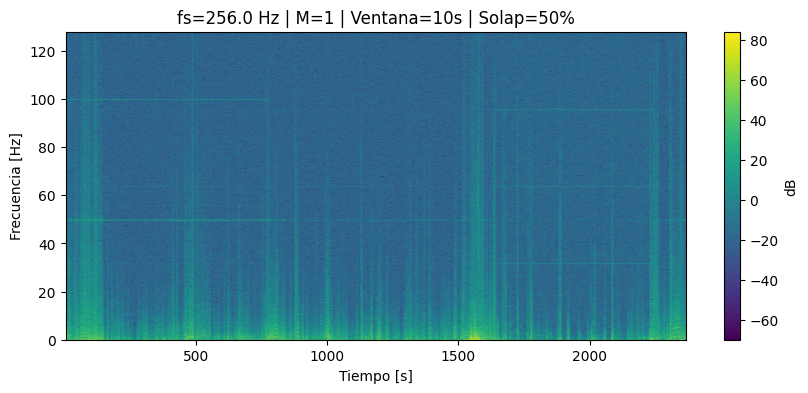

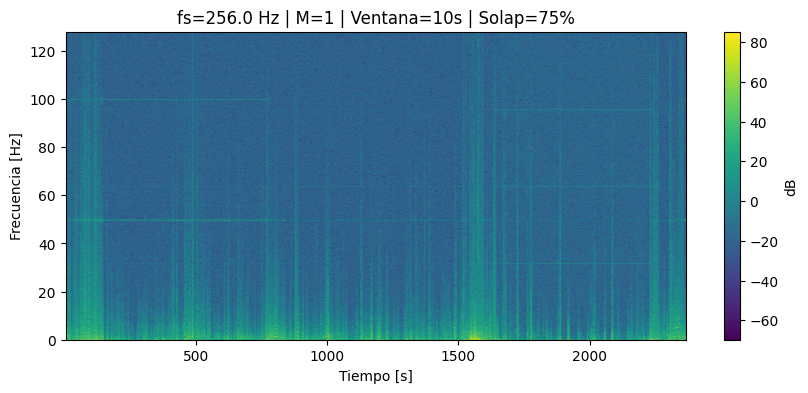

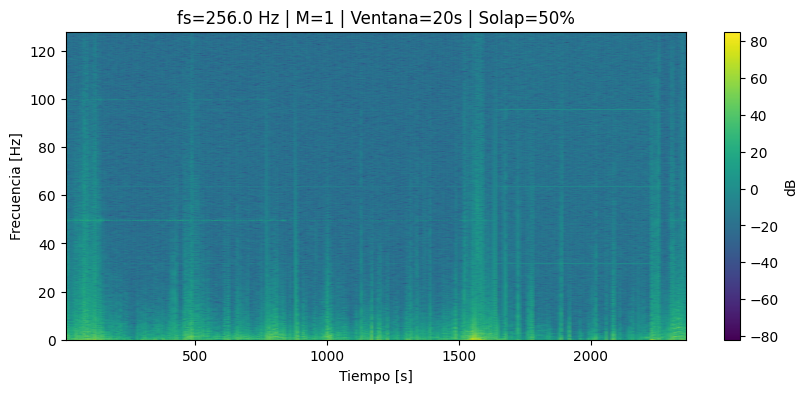

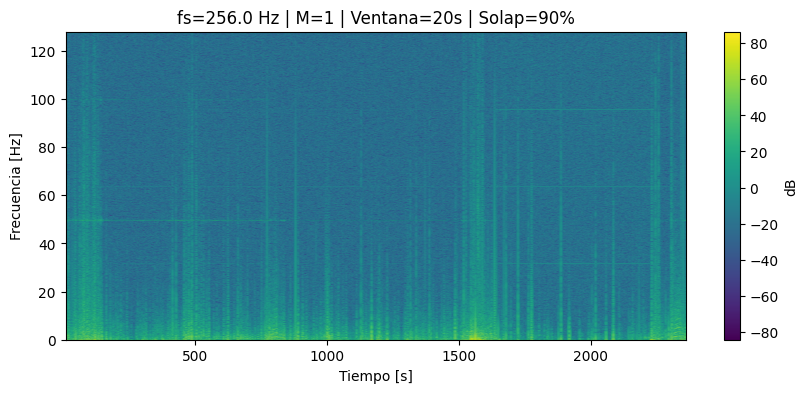

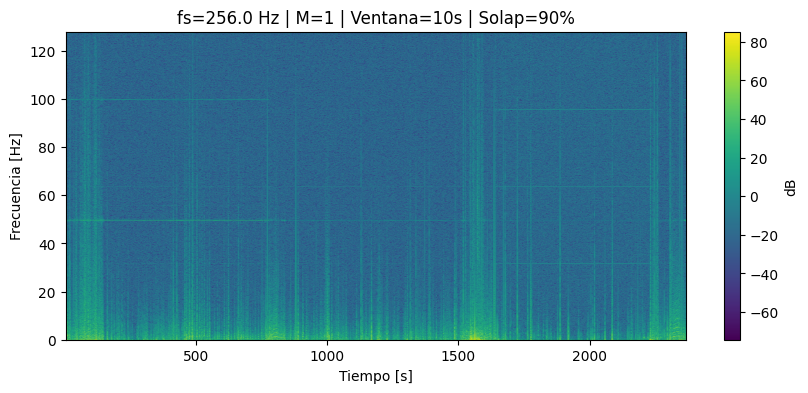

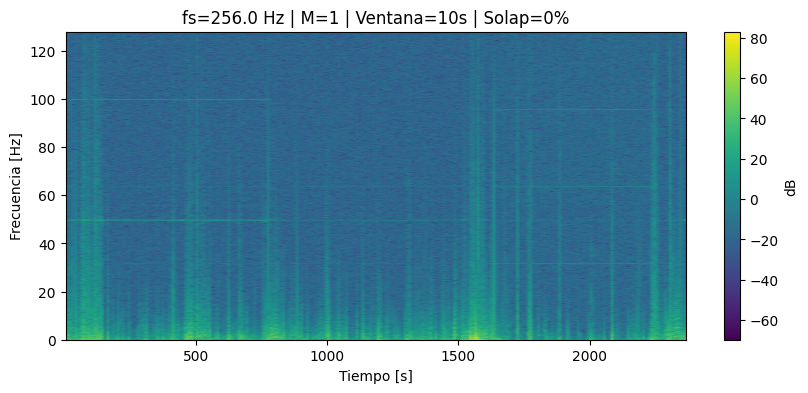

In [ ]:
plot_spectrogram_param(emg, fs_exg, factor_diezmado=1, duracion_ventana=10, solapamiento=0.5)
plot_spectrogram_param(emg, fs_exg, factor_diezmado=1, duracion_ventana=10, solapamiento=0.75)
plot_spectrogram_param(emg, fs_exg, factor_diezmado=1, duracion_ventana=20, solapamiento=0.5)
plot_spectrogram_param(emg, fs_exg, factor_diezmado=1, duracion_ventana=20, solapamiento=0.9)
plot_spectrogram_param(emg, fs_exg, factor_diezmado=1, duracion_ventana=10, solapamiento=0.9)
plot_spectrogram_param(emg, fs_exg, factor_diezmado=1, duracion_ventana=10, solapamiento=0)

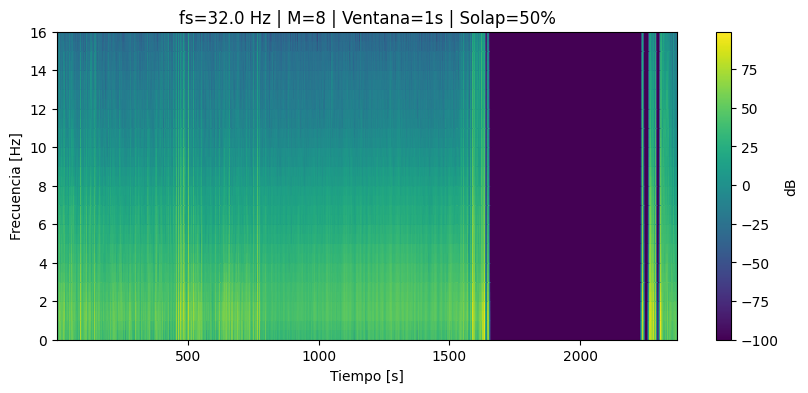

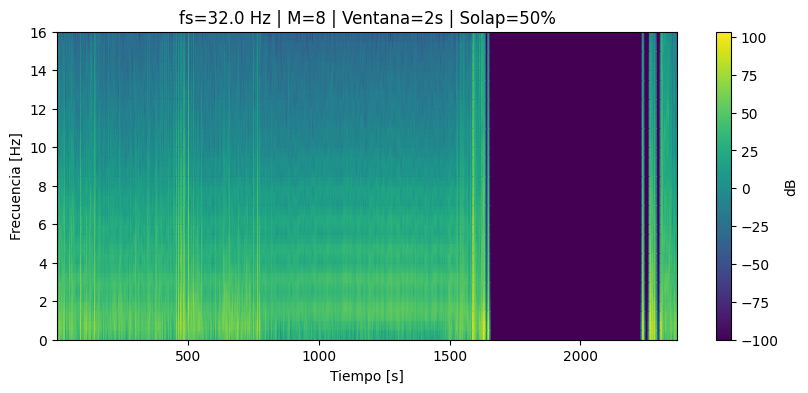

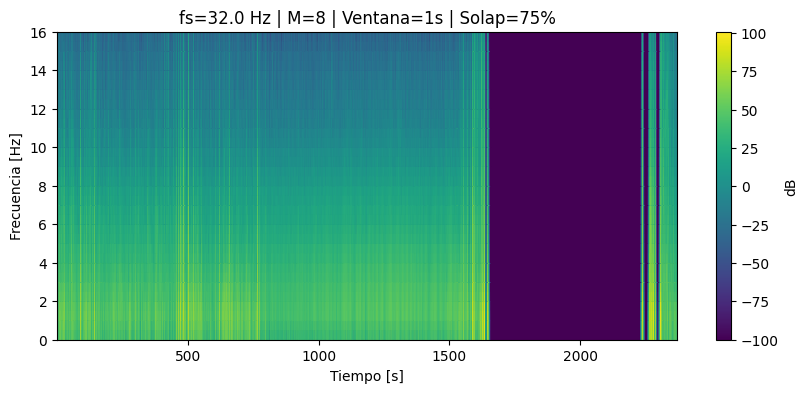

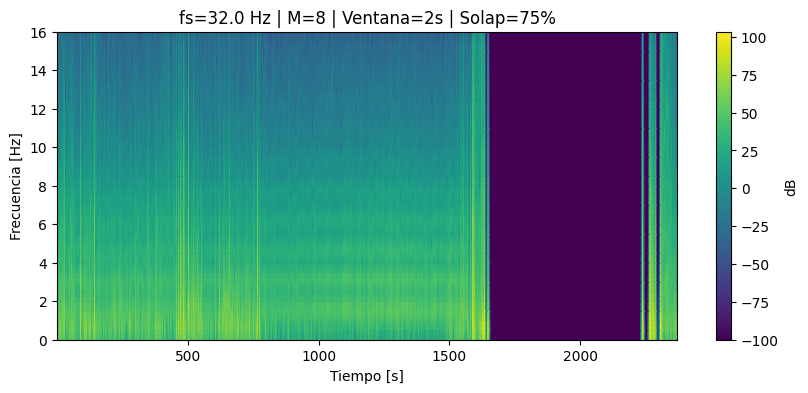

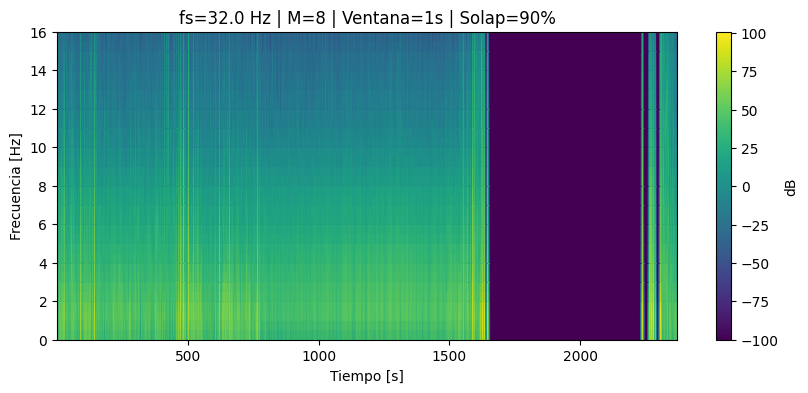

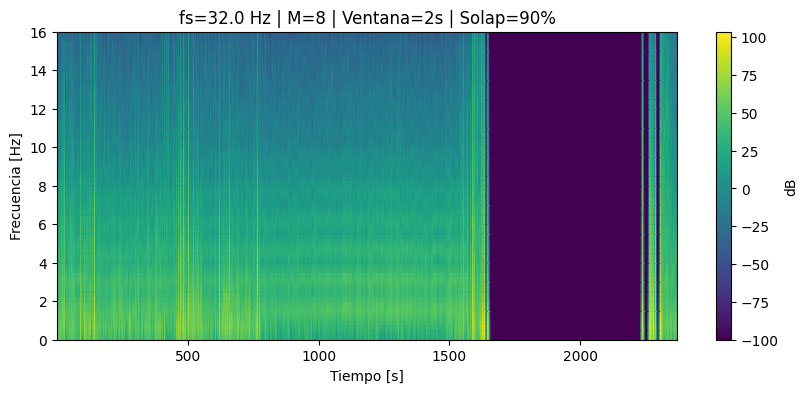

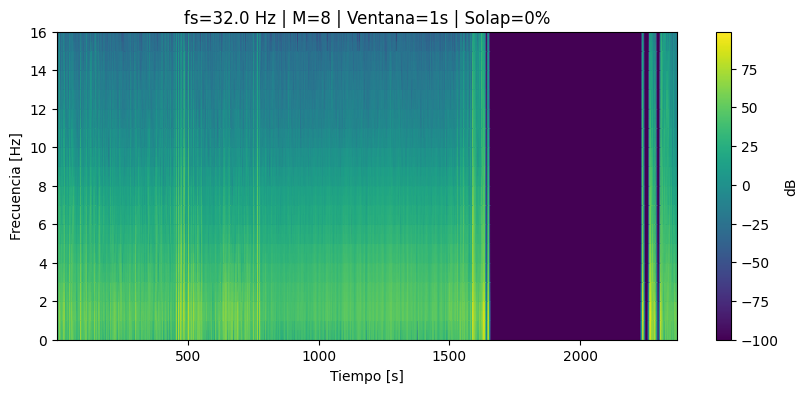

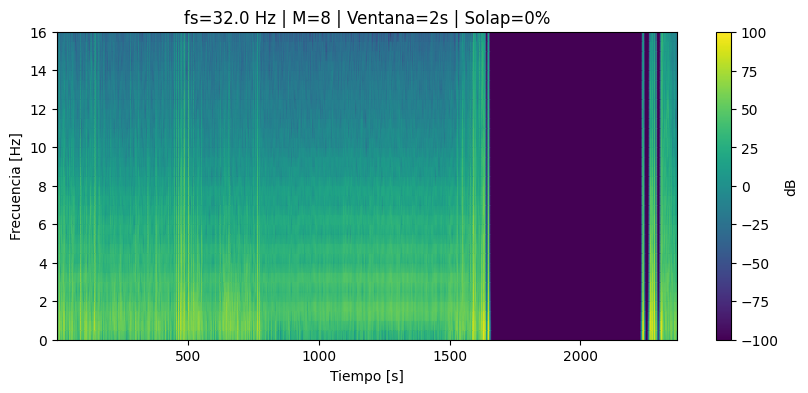

In [ ]:
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=8, duracion_ventana=1, solapamiento=0.5)
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=8, duracion_ventana=2, solapamiento=0.5)
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=8, duracion_ventana=1, solapamiento=0.75)
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=8, duracion_ventana=2, solapamiento=0.75)
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=8, duracion_ventana=1, solapamiento=0.9)
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=8, duracion_ventana=2, solapamiento=0.9)
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=8, duracion_ventana=1, solapamiento=0)
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=8, duracion_ventana=2, solapamiento=0)

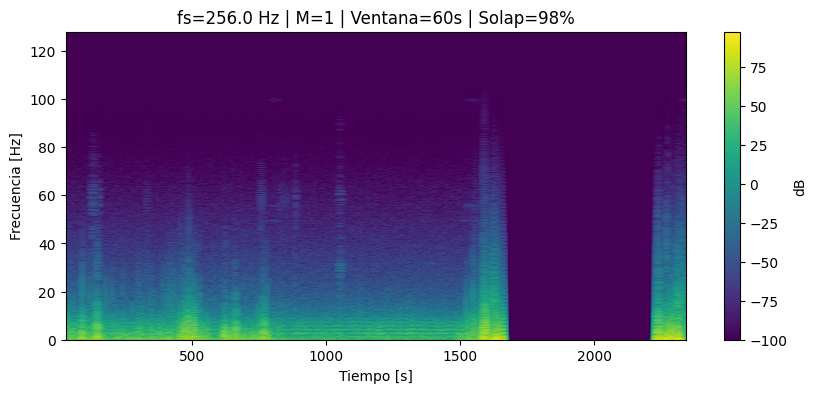

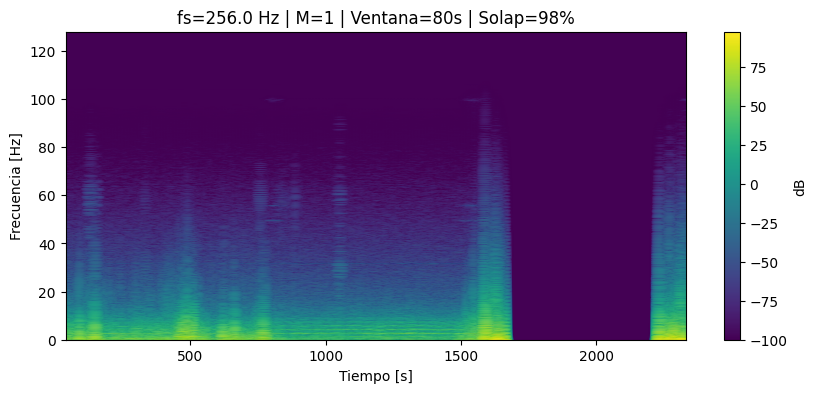

In [ ]:
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=1, duracion_ventana=60, solapamiento=0.98)
plot_spectrogram_param(bvp_clean, fs_exg, factor_diezmado=1, duracion_ventana=80, solapamiento=0.98)

## IMU FEATURES (prueba maria)

In [ ]:
# Magnitud
magnitud_aceleracion = np.sqrt(ax**2 + ay**2 + az**2)
print("Magnitud de la aceleración:", magnitud_aceleracion)

Magnitud de la aceleración: 0        9.918209
1        9.997854
2        9.989668
3        9.874814
4        9.884427
           ...   
75861    9.926784
75862    9.924290
75863    9.913440
75864    9.915085
75865    9.937212
Length: 75866, dtype: float64


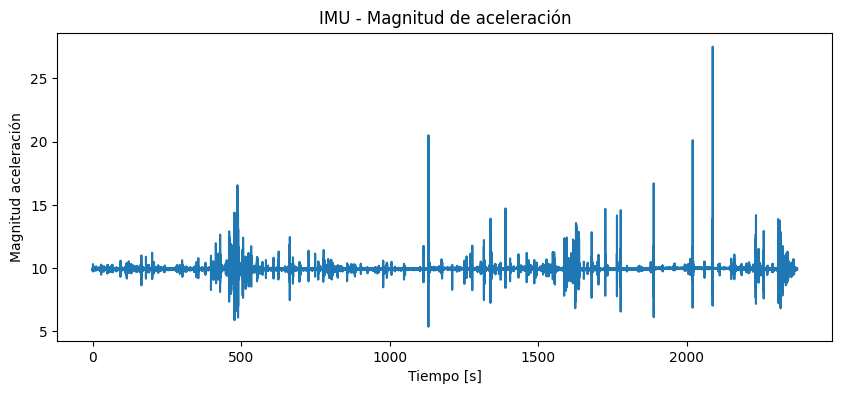

In [ ]:
tiempo = np.arange(len(magnitud_aceleracion)) / fs_imu

plt.figure(figsize=(10,4))
plt.plot(tiempo, magnitud_aceleracion)
plt.xlabel("Tiempo [s]")
plt.ylabel("Magnitud aceleración")
plt.title("IMU - Magnitud de aceleración")
plt.show()

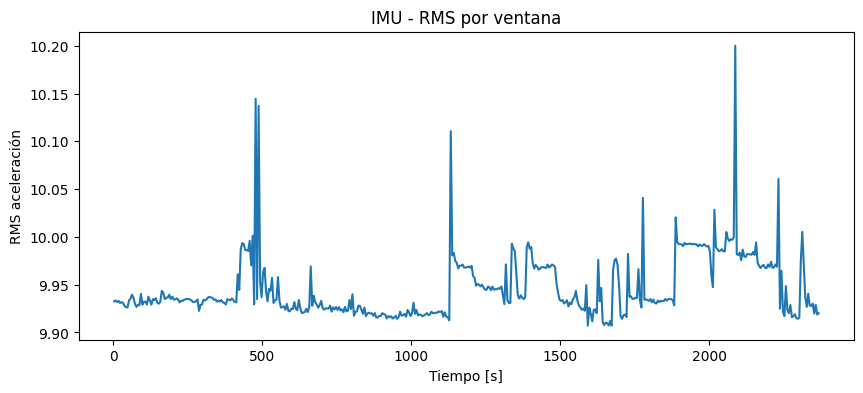

In [ ]:
ventana = int(fs_imu * 5)  # 5 segundos

rms = []
tiempos = []

for i in range(0, len(magnitud_aceleracion)-ventana, ventana):
    segmento = magnitud_aceleracion[i:i+ventana]
    rms.append(np.sqrt(np.mean(segmento**2)))
    tiempos.append((i + ventana/2)/fs_imu)

plt.figure(figsize=(10,4))
plt.plot(tiempos, rms)
plt.xlabel("Tiempo [s]")
plt.ylabel("RMS aceleración")
plt.title("IMU - RMS por ventana")
plt.show()